# Initializations

In [1]:
import numpy as np
import pandas as pd

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

import warnings
warnings.filterwarnings('ignore')

import gzip
import cPickle as pickle

from PIL import Image

import sys
sys.path.append("../pytorch_utils/")
from loader_dataframe import ImageDataFrame, grayscale_loader



In [3]:
from IPython import parallel

rc = parallel.Client()
all_engines = rc[:]
lbv = rc.load_balanced_view()

print len(all_engines)

48


In [4]:
%%px --local 

from skimage.transform import resize
from skimage.io import imread, imsave

def read_img(f, imgSize=None):
    img = imread(f)
    img[img==128] = 0 # this removes gray patches that indicate no data/water bodies
    if imgSize is not None:
        img = resize(img, (imgSize, imgSize), preserve_range=True)
    img = img / img.max()
    return img

# Define & exemplify stats of interest

In [5]:
myfile = '/home/data/world-cities/urban_areas_over_10kpop/SAR_fr_paris,-fr-(pop-2.1M)_very-large_2110694_48.8667_2.3333.png'
myfile

'/home/data/world-cities/urban_areas_over_10kpop/SAR_fr_paris,-fr-(pop-2.1M)_very-large_2110694_48.8667_2.3333.png'

#### Fraction of occupied area

In [6]:
%%px --local 

compute_pct_occupied = lambda img: (img).sum() / float(img.shape[0]*img.shape[1])

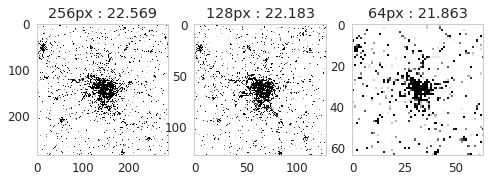

In [7]:
sns.set_context("notebook", font_scale=1.2)
# using PIL (which is what torchvision uses)

img = grayscale_loader(myfile)

img_64 = img.resize((64,64))
img_128= img.resize((128,128))

fig, ax = plt.subplots(1,3, figsize=(8,4))
ax[0].imshow(img); ax[0].set_title("256px : %2.3f"%compute_pct_occupied(np.array(img)))
ax[1].imshow(img_128); ax[1].set_title("128px : %2.3f"%compute_pct_occupied(np.array(img_128)))
ax[2].imshow(img_64); ax[2].set_title("64px : %2.3f"%compute_pct_occupied(np.array(img_64)))

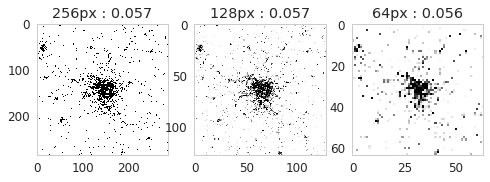

In [8]:
# using skimage

img = read_img(myfile)

img_64 = resize(img, (64,64), preserve_range=True)
img_128= resize(img, (128,128), preserve_range=True)

fig, ax = plt.subplots(1,3, figsize=(8,4))
ax[0].imshow(img); ax[0].set_title("256px : %2.3f"%compute_pct_occupied(img))
ax[1].imshow(img_128); ax[1].set_title("128px : %2.3f"%compute_pct_occupied(img_128))
ax[2].imshow(img_64); ax[2].set_title("64px : %2.3f"%compute_pct_occupied(img_64))

#### Distribution of patch areas

In [9]:
%%px --local 

from skimage import morphology

def compute_patch_areas(M):
    mask = morphology.label(M)
    areas = []
    for i in np.arange(1,mask.max()):
        areas.append((i,(mask==i).sum()))
    areas.sort(key=lambda x: x[1], reverse=True)
    return areas, mask

def compute_patch_area_distribution(img, bins=None):
    areas, mask = compute_patch_areas(img)
    area_sizes = [x[1] for x in areas]
    N_counts, bins = np.histogram(area_sizes, bins=bins)
    mask = None; area_sizes = None
    return np.log(N_counts), bins, areas

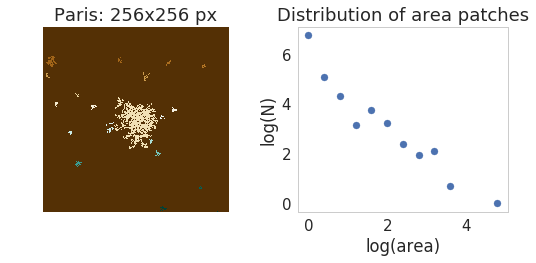

In [23]:
sns.set_context("notebook", font_scale=1.5)

areas, mask = compute_patch_areas(img)

area_sizes = [x[1] for x in areas]
log_area_bins = np.logspace(np.log(min(area_sizes)), np.log(max(area_sizes)), 20, base=np.exp(1))
log_N, _, _ = compute_patch_area_distribution(img, bins=log_area_bins)

# plot just top 20 areas
mask1 = mask.copy()
for a in areas[20:]:
    mask1[mask1==a[0]] = 0

fig, ax = plt.subplots(1,2, figsize=(8,4))
imgplot = ax[0].imshow(mask1)
imgplot.set_cmap('BrBG')
ax[0].set_title("Paris: 256x256 px")
ax[0].axis("off")

# plot distribution of area sizes
ax[1].scatter(np.log(log_area_bins[:-1]), log_N, marker="o")
ax[1].set_title("Distribution of area patches")
ax[1].set_ylabel("log(N)")
ax[1].set_xlabel("log(area)")

plt.tight_layout()

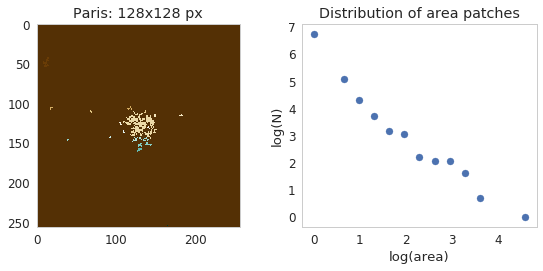

In [11]:
areas, mask = compute_patch_areas(resize(img, (256,256), preserve_range=True))

area_sizes = [x[1] for x in areas]
log_area_bins = np.logspace(np.log(min(area_sizes)), np.log(max(area_sizes)), 20, base=np.exp(1))
log_N, _, _ = compute_patch_area_distribution(img, bins=log_area_bins)

# plot just top 20 areas
mask1 = mask.copy()
for a in areas[20:]:
    mask1[mask1==a[0]] = 0

fig, ax = plt.subplots(1,2, figsize=(8,4))
imgplot = ax[0].imshow(mask1)
imgplot.set_cmap('BrBG')
ax[0].set_title("Paris: 128x128 px")


# plot distribution of area sizes
ax[1].scatter(np.log(log_area_bins[:-1]), log_N, marker="o")
ax[1].set_title("Distribution of area patches")
ax[1].set_ylabel("log(N)")
ax[1].set_xlabel("log(area)")

plt.tight_layout()

In [12]:
%%px --local 

import scipy.misc

def fractal_dimension(Z, threshold=0.9):

    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes[1:]), np.log(counts[:-1]), 1)
    return -coeffs[0], np.log(sizes), np.log(counts)

('Minkowski-Bouligand dimension (computed): ', 1.6216897216784427)
('Haussdorf dimension (theoretical):        ', 1.5849625007211563)


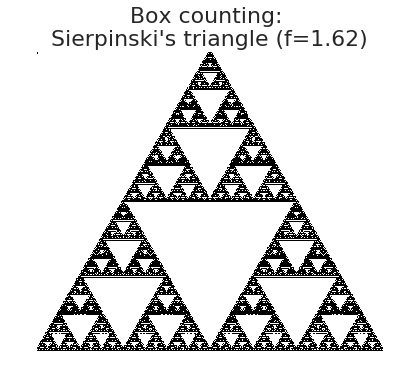

In [17]:
I = read_img("sierpinski.png")
plt.imshow(1-I)
plt.axis("off")
plt.title("Box counting: \nSierpinski's triangle (f=%2.2f)"%fractal_dimension(I)[0], 
          fontsize=22)

print("Minkowski-Bouligand dimension (computed): ", fractal_dimension(I)[0])
print("Haussdorf dimension (theoretical):        ", (np.log(3)/np.log(2)))

In [20]:
frac_dim, log_box_sizes, log_box_counts = fractal_dimension(img)
frac_dim

1.5963524909615108

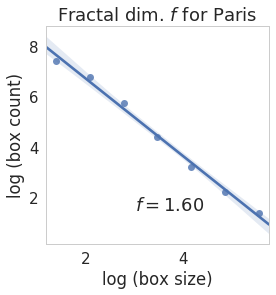

In [24]:
sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(4,4))
ax = sns.regplot(log_box_sizes, log_box_counts, lowess=False)
plt.xlabel("log (box size)")
plt.ylabel("log (box count)")
plt.title("Fractal dim. $f$ for Paris")

ax.annotate('$f=$%.2f'%frac_dim, xy=(2, 1), xytext=(3, 1.5))


(-0.5, 285.5, 285.5, -0.5)

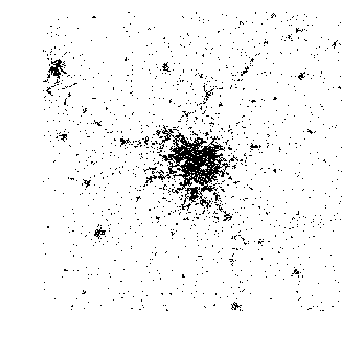

In [19]:
plt.imshow(img)
plt.axis("off")

# Set up data sources: real data

In [53]:
dataroot = "/home/data/world-cities/"

In [63]:
regions_df = pd.read_csv("/home/data/countries_regions.csv")

country2region = {r:c for r,c in zip(regions_df['alpha-2'].str.lower(), regions_df['region'])}


### Training data is all cities > 10k population

In [99]:
import glob

files = glob.glob(dataroot + "urban_areas_over_10kpop/SAR*.png")
files_df = []
for f in files:
    s = f.split("/")
    fname = s[-1]
    cls = fname.split("_")[3]
    _,country,city,_,pop,lat,lon = fname.split("_")
    files_df.append((f, cls, country, pop))
    
files_df = pd.DataFrame(files_df, \
                columns=["filename", "class", "country", "population"])
files_df['city'] = files_df['filename'].apply(lambda s: os.path.basename(s).split("_")[2].replace("-"," "))
files_df['region'] = files_df['country'].apply(lambda x: country2region[x] if x in country2region else np.nan)
files_df['source'] = files_df['filename'].apply(lambda s: os.path.basename(s).split("_")[0])

len(files_df)

25024

In [78]:
files_df.head()

,filename,class,country,population,city,region,source
0,/home/data/world-cities/urban_areas_over_10kpo...,very-small,us,44071,"saint louis park, us (pop 44.1k)",Americas,SAR
1,/home/data/world-cities/urban_areas_over_10kpo...,very-small,us,44174,"pittsfield, us (pop 44.2k)",Americas,SAR
2,/home/data/world-cities/urban_areas_over_10kpo...,very-small,br,42721,"caninde, br (pop 42.7k)",Americas,SAR
3,/home/data/world-cities/urban_areas_over_10kpo...,very-small,in,14046,"semaria, in (pop 14.0k)",Asia,NLI
4,/home/data/world-cities/urban_areas_over_10kpo...,very-small,es,22264,"baranain, es (pop 22.3k)",Europe,NLI


In [79]:
f

'/home/data/world-cities/urban_areas_over_10kpop/PNM_gn_tougue,-gn-(pop-25.5k)_very-small_25530_11.4500_-11.6833.png'

### Separate data that contains more carefully-filtered samples 
(to remove overlap between cities that are close together in large metro regions)

In [114]:
files = glob.glob(dataroot + "/urban_areas_over_10kpop_pruned/SAR*.png")
test_df = []
for f in files:
    s = f.split("/")
    fname, cls = s[-1], s[-2]
    _,country,city,_,pop,lat,lon = fname.split("_")
    test_df.append((f, cls, country, pop))
    
test_df = pd.DataFrame(test_df, \
                columns=["filename", "class", "country", "population"])

# hack to remove some cities that are too close to Paris
# just an example we looked at
# this means that the filtering needs to be debugged
test_df = test_df[(~test_df['filename'].str.contains("argenteuil")) & \
                  (~test_df['filename'].str.contains("montreuil"))]

test_df['city'] = test_df['filename'].apply(lambda s: os.path.basename(s).split("_")[2].replace("-"," "))
test_df['region'] = test_df['country'].apply(lambda x: country2region[x] if x in country2region else np.nan)

len(test_df)

3015

# Compute stats on all images

In [115]:
myfiles_df = test_df.copy() # real images
# myfiles_df = files_df.copy() # real images
# myfiles_df = files_sel.copy() # simulated images

print len(myfiles_df)

3015


In [82]:
%%px --local

import numpy as np
import os

def compute_stats(f, imgSize=None, max_log_area=None):
    try:
        img = read_img(f.replace("//",'/'), imgSize) 
    except:
        return None, None, None, None
    pct_occupied = compute_pct_occupied(img)
    bins = np.logspace(1, max_log_area, 20, base=np.exp(1))
    log_N, _, areas = compute_patch_area_distribution(img, bins=bins)
    log_N[np.isinf(log_N)] = 0
    fd, log_sizes, log_counts = fractal_dimension(img)
    
    top_k_areas = np.zeros(20)
    top_k_areas[:min([20,len(areas)])] = [x[1] for x in areas[:20]]
    
    img = None; bins = None;
    # gc.collect()
    return f, pct_occupied, log_N, top_k_areas, fd, log_counts

In [83]:
f = myfiles_df['filename'].iloc[0]
f

'/home/data/world-cities/urban_areas_over_10kpop/SAR_us_saint-louis-park,-us-(pop-44.1k)_very-small_44071_44.9483_-93.3478.png'

In [88]:
compute_stats(f, imgSize=None, max_log_area=6)

('/home/data/world-cities/urban_areas_over_10kpop/SAR_us_saint-louis-park,-us-(pop-44.1k)_very-small_44071_44.9483_-93.3478.png',
 0.025233507750990269,
 array([ 3.66356165,  2.99573227,  2.56494936,  2.94443898,  2.30258509,
         0.        ,  1.79175947,  1.09861229,  1.38629436,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]),
 array([ 800.,   44.,   30.,   29.,   28.,   25.,   23.,   20.,   19.,
          18.,   17.,   16.,   16.,   15.,   15.,   14.,   11.,   10.,
          10.,   10.]),
 1.3773389397721427,
 array([ 1.38629436,  2.19722458,  3.21887582,  4.35670883,  5.32300998,
         5.96614674,  6.65544035]))

In [85]:
%%timeit  
compute_stats(f, imgSize=None, max_log_area=9)

10 loops, best of 3: 91.8 ms per loop


In [86]:
%%timeit 
compute_stats(f, imgSize=128, max_log_area=6.7)

100 loops, best of 3: 3.67 ms per loop


In [116]:
res_orig = lbv.map_async(lambda f: compute_stats(f, imgSize=None, max_log_area=6), \
                         myfiles_df['filename'].values.tolist())
stats_orig = pd.DataFrame(res_orig.result(), 
                          columns=["filename", "build pct", 
                                   "patch distr", "top patch areas", "fractal dim", "box counts"])

In [117]:
res_128 = lbv.map_async(lambda f: compute_stats(f, imgSize=128, max_log_area=5), \
                         myfiles_df['filename'].values.tolist())
stats_128 = pd.DataFrame(res_128.result(), 
                          columns=["filename", "build pct", 
                                   "patch distr", "top patch areas", "fractal dim", "box counts"])

In [118]:
res_64 = lbv.map_async(lambda f: compute_stats(f, imgSize=64, max_log_area=4), \
                         myfiles_df['filename'].values.tolist())
stats_64 = pd.DataFrame(res_64.result(), 
                           columns=["filename", "build pct", 
                                   "patch distr", "top patch areas", "fractal dim", "box counts"])

In [119]:
myfiles_df = pd.concat([myfiles_df.reset_index().drop("index",1), 
    stats_128.rename(columns={"build pct":"build pct 128", 
                               "fractal dim":"fractal dim 128",
                               "top patch areas":"top patch areas 128",
                               "box counts":"box counts 128",
                               "patch distr":"patch distr 128"}).drop("filename",1),
    stats_orig.rename(columns={"build pct":"build pct 286", 
                               "fractal dim":"fractal dim 286",
                               "top patch areas":"top patch areas 286",
                               "box counts":"box counts 286",
                               "patch distr":"patch distr 286"}).drop("filename",1),
    stats_64.rename(columns={"build pct":"build pct 64", 
                               "fractal dim":"fractal dim 64",
                               "top patch areas":"top patch areas 64",
                               "box counts":"box counts 64",
                               "patch distr":"patch distr 64"}).drop("filename",1)
], axis=1)

myfiles_df.dropna(inplace=True)

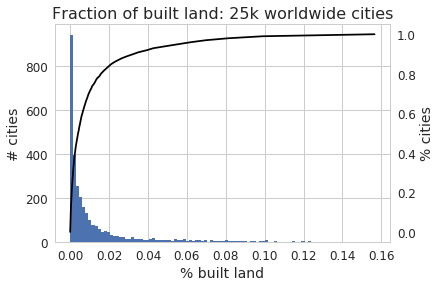

In [120]:
fig, ax = plt.subplots(figsize=(6,4))
ax2 = ax.twinx()
myfiles_df['build pct 286'].hist(bins=100, ax=ax)
q = myfiles_df['build pct 286'].quantile(np.linspace(0.0,1,100))
ax2.plot(q, q.index, label="cdf", color="black")
sns.set_style("whitegrid", {'axes.grid' : False})
plt.title("Fraction of built land: 25k worldwide cities", fontsize=16)
ax.set_xlabel("% built land", fontsize=14)
ax.set_ylabel("# cities", fontsize=14)
ax2.set_ylabel("% cities", fontsize=14)


In [121]:
q = myfiles_df['build pct 286'].quantile(np.linspace(0.0,1,10))

print q

myfiles_df['decile'] = myfiles_df['build pct 286'].apply(lambda x: np.searchsorted(q.values, x) )

0.000000    0.000012
0.111111    0.000364
0.222222    0.000917
0.333333    0.001752
0.444444    0.003107
0.555556    0.005219
0.666667    0.008338
0.777778    0.013919
0.888889    0.029301
1.000000    0.156524
Name: build pct 286, dtype: float64


#### Save to file

In [122]:
# myfiles_df.to_csv(dataroot + "/urban_areas_over_10kpop_stats.csv")

myfiles_df.to_csv(dataroot + "/urban_areas_over_10kpop_pruned_stats.csv")

# myfiles_df.to_csv(dataroot + "/simulations_stats.csv")